# Assignment 2: Cell Tower Installation

## Instructions

This assignment is worth 10/100 points. 

You can do this assignment with someone else and it is about Local Search Algorithms, more specifically, Genetic Algorithms.

Answer to all the questions in english, argument, and justify your answers using the obtained results.

### Names

- Nicolas Cari Rodriguez
- Christian Rivero Arnez

### Deadline
March 18th, 2023 at 23.59

### Some more Instructions
- You need to fill in your answers here and submit this jupyter notebook via NEO.
- It should run smoothly.
- Any compilation error will affect your total score. 


### Important before starting! 

- Only one of you should send the assignment, NOT BOTH!
- DO NOT copy the answers from internet nor from your classmates.
- If there are two or more groups that were discovered cheeting, then they will be penalized with 0/10.
- Use your brain and the material seen in class to program this assignment.
- You should be able to explain and modify your code according to your (or my) needs. 

## Problem Description
A local cellphone bolivian company wants to give cell phone signal to $n$ cities located in a remote place somewhere in Bolivia. 

They want to install cell towers that gives signal for $r$ Km around. The cost of installing a tower on land is not the same as the cost of installing it on a lake or on top of a hill. Thus, they want to minimize the amount of towers to be used and also the cost to be spent by installing each of them while giving signal to all cities (total coverage) such as in the picture below where we can see that all cities are covered. 

<div>
<img src="img/cities.png" width="500"/>
</div>


We will suppose that the signal radius of each tower is the same, independently if the tower is on top of a hill or on the land. 

### Some code to help you focus on the important part

We have already implemented part of the code to help you deal with some aspects of the problem such as the map representation, the cell tower coverage, part of the chromosome representation. 

In [61]:
import numpy as np
import random
from enum import Enum, auto
import copy
from matplotlib import colors, pyplot as plt
import matplotlib.patches as mpatches

In [96]:
class Chromosome: 
    rows = 0 
    cols = 0
    
    def __init__(self, gens):
        self.gens = gens
        self.FitnessValue=0
        # fitness function can be defined outside the class
        #self.ind_fitness = self.__class__.fitness_function(self.get_coordinates())
    def __gt__(self,otherChromosome):
        return self.FitnessValue>otherChromosome.FitnessValue
    @classmethod
    def generate_random(cls, tower_pr):
        '''
            It generates a random chromosome
            tower_pr is the probability to add a tower to a certain position
            higher this amount more towers you will have
            lower this amount less towers you will have
        '''
        gens = [0] * cls.rows * cls.cols 
        for i in range(cls.rows * cls.cols): 
            if random.random() < tower_pr:
                # indicates the presence of a tower
                gens[i] = 1 
        
        return Chromosome(gens)   

    @classmethod 
    def set_fitness_function(cls, fun): 
        cls.fitness_function = fun

    def count_towers(self): 
        return sum(self.gens)  

    def get_coordinates(self): 
        ''' Maps gens to map coordinates '''
        r = self.__class__.rows 
        c = self.__class__.cols 
        matrix = [[None] * c for _ in range(r)] 
        
        for i in range(r): 
            for j in range(c): 
                matrix[i][j] = self.gens[i * r + j] 
        
        return np.array(matrix)
          
            

In [63]:
class SquareType(Enum): 
    water = auto() 
    land = auto() 
    hill = auto() 
    city = auto()

In [64]:
class Square: 
    def __init__(self, type, needs_coverage, tower_cost, is_covered = False): 
        self.tower_cost = tower_cost 
        self.needs_coverage = needs_coverage
        self.is_covered = is_covered 
        self.type = type 
        self.has_radar = False

In [65]:
class Landscape:
    def __init__(self, matrix): 
        self.matrix = matrix 
        self.costOfTowersAdded=0
    
    def rows(self): 
        return len(self.matrix) 
    
    def cols(self): 
        return len(self.matrix[0])
    
    def addToTowerCost(self,x,y):
        square=self.matrix[y][x]
        self.costOfTowersAdded+=square.tower_cost
      
        
        
    def add_towers(self, centroids, radius):
        r = radius
        
        for idx, x in np.ndenumerate(centroids):
            if centroids[idx[0],idx[1]] == 1:
                a, b = idx[0], idx[1]
                self.matrix[a][b].has_radar = True
                self.addToTowerCost(a,b)
                # draw the circle
                for y in range(self.rows()):
                    for x in range(self.cols()):
                        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
                        if abs((x-a)**2 + (y-b)**2) <= r**2:
                            self.matrix[y][x].is_covered = True
                            
    def uncovered_count(self):
        '''uncovered cities'''
        count = 0
        
        for y in range(self.rows()):
            for x in range(self.cols()):
                if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == False:
                    count+=1
        return count

In [66]:
def generate_random_landscape(points, weights, rows, cols): 
    matrix = [[None] * cols for _ in range(rows)] 
    for i in range(rows): 
        for j in range(cols): 
            p = random.choices(points, weights.values()) 
            square = copy.deepcopy(p[0])
            
            square.tower_cost = square.tower_cost #round(square.tower_cost * (1 + random.uniform(0, .1))) 
            matrix[i][j] = square 
    
    return Landscape(matrix)

plt.rcParams['figure.figsize'] = [5,5]

def plot_landscape(landscape): 
    square_colors = { 
        SquareType.water: 1, 
        SquareType.land: 11, 
        SquareType.hill: 21, 
        SquareType.city: 31
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()):
        for j in range(landscape.cols()):
            m[i, j] = square_colors[landscape.matrix[i][j].type]
            
    col_list = ['blue', 'green', 'brown', 'black']
    labels = [s.name for s in square_colors.keys()] 
    cmap = colors.ListedColormap(col_list)
    bounds = [0, 10, 20, 30, 40] 
    norm = colors.BoundaryNorm(bounds, cmap.N) 
            
    plt.imshow(m, cmap = cmap, norm = norm) 
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1) 
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.3, 1), borderaxespad = 0.)
    plt.title('Landscape')
    plt.show()
    
def plot_coverage(landscape, title = "Coverage"):
    coverage_colors = { 
        'neutral': 1, 
        'is covered': 11, 
        'needs coverage': 21 
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    for i in range(landscape.rows()):
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].is_covered: 
                m[i, j] = coverage_colors['is covered'] 
            elif not landscape.matrix[i][j].needs_coverage: 
                m[i, j] = coverage_colors['neutral'] 
            elif landscape.matrix[i][j].needs_coverage:
                m[i, j] = coverage_colors['needs coverage']

    col_list = ['white', 'yellow', 'black'] 
    labels = list(coverage_colors.keys()) 
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20, 30] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1)
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.5, 1), borderaxespad = 0.)
    plt.title('Coverage')
    plt.show() 

def plot_costs(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            m[i, j] = landscape.matrix[i][j].tower_cost 
    plt.imshow(m, cmap = plt.cm.Reds)
    plt.colorbar()
    plt.title('Tower Construction Costs')
    plt.show()
    
def plot_towers_position(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].has_radar:
                m[j, i] = 11
            else:
                m[j, i] = 1

    col_list = ['white','black']
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.title('Towers Position')
    plt.show()

The cost of installing a cell tower on:
- Water (such as lakes): \$us 300K
- City: \$us 200K
- Hill: \$us 100K
- Land: \$us 30K

Each tower has a coverage of 7 Km around it.

# F: -3810
# Cell Towers: 6
# Cost: 590
Uncovered Cities before cell towers: 30
Uncovered Cities after cell towers: 24


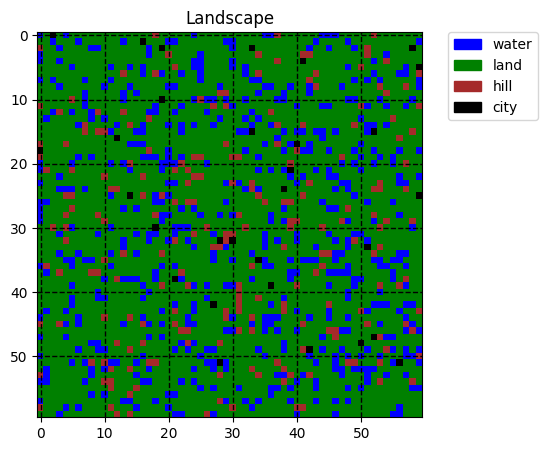

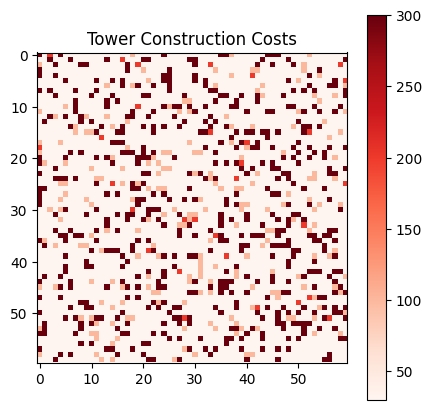

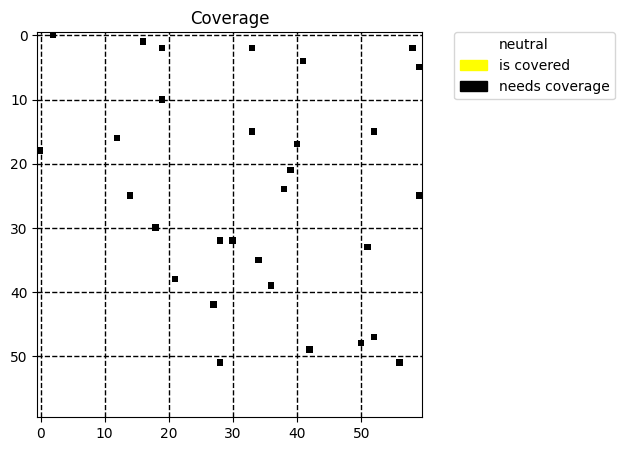

Coverage after setting up the cell towers:


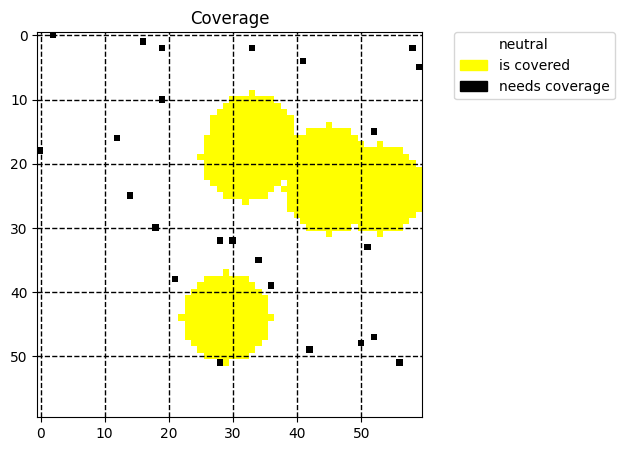

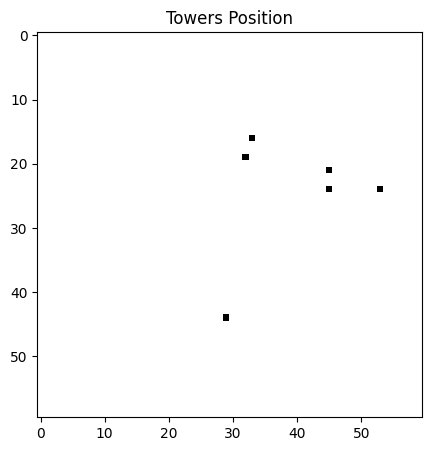

In [81]:
# the purpose of this line is to reproduce your results
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols

# fitness function undefined yet 
def fitness_function(cr,worstCostOfPopulation,penalty=100): 
    return cr.cost-worstCostOfPopulation-cr.uncovered*penalty

Chromosome.set_fitness_function(fitness_function) 
cr = Chromosome.generate_random(.001)

test_landscape = copy.deepcopy(landscape) 
# coverage of 7km
test_landscape.add_towers(cr.get_coordinates(), 7)

towers = cr.count_towers() 
cr.uncovered = test_landscape.uncovered_count() 
cr.cost=test_landscape.costOfTowersAdded
F=cr.fitness_function(2000)
print(f'# F: {F}') 
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cr.cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {cr.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

In [119]:
def fitness_function(cr,cities,worstValueOfPopulation,buff=3): 
    f=-cr.cost+worstValueOfPopulation+(cities-cr.uncovered)*buff
    
    return f
rows = 30
cols = 30
Chromosome.rows = rows
Chromosome.cols = cols
Chromosome.set_fitness_function(fitness_function) 
landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)
def crossover(parent1, parent2,points=2,failProbability=0.3):
    crossover_points=sorted(random.sample(range(len(parent1)), points))
    if random.randint(0,1)<=failProbability:
        return parent1.gens,parent2.gens
    child1=[]
    child2=[]
    order=0
    lastPoint=0
    for point in crossover_points:
        if order==0:
            child1.append(parent1[lastPoint:point])
            child2.append(parent2[lastPoint:point])
            order=1
            lastPoint=point
        else:
            child1.append(parent2[lastPoint:point])
            child2.append(parent1[lastPoint:point])
            order=0
            lastPoint=point
    return child1,child2
def mutateGen(gens,mutationProb=0.1):
    if random.randint(0,1)>mutationProb:
        return gens
    genIndex=random.sample(range(len(gens)), 1)
    if gens[genIndex]==0:
        gens[genIndex]=1
    else:
        gens[genIndex]=0
    return gens
def geneticAlgorithm(landscape,cities,P=50,probToGenerateTower=0.001,penaltyPerCity=100):
    basePopulation=[]
    FitnessOfLastPopulation=None
    generationsWithSameFitness=0
    for _ in range(20):
        probabilities=[]
        worstValueOfPopulation=0
        FitnessOfPopulation=0
        bestPopulationValue=None
        for _ in range(P):
            newCr=Chromosome.generate_random(probToGenerateTower)
            landscapeCopy = copy.deepcopy(landscape) 
            landscapeCopy.add_towers(newCr.get_coordinates(), 7)
            newCr.uncovered=landscapeCopy.uncovered_count() 
            newCr.cost=landscapeCopy.costOfTowersAdded
            if newCr.cost>worstValueOfPopulation:
                worstValueOfPopulation=newCr.cost
            basePopulation.append(newCr)
        for cr in basePopulation:
            cr.FitnessValue=cr.fitness_function(cities,worstValueOfPopulation,penaltyPerCity)
            FitnessOfPopulation+=cr.FitnessValue
        bestPopulationValue=max(basePopulation)
        for cr in basePopulation:
            probabilities.append(cr.FitnessValue/FitnessOfPopulation)
        newPopulation=[]
        while len(newPopulation)==P:
            cr1,cr2=np.random.choice(basePopulation,2,p=probabilities)
            crx,crz=crossover(cr1,cr2,2)
            crx=mutateGen(crx)
            crz=mutateGen(crz)
            newPopulation.append(Chromosome(crx))
            if(len(newPopulation)!=P):
                newPopulation.append(Chromosome(crz))
        if(FitnessOfLastPopulation==FitnessOfPopulation):
            generationsWithSameFitness+=1
        else:
            generationsWithSameFitness=0
        FitnessOfLastPopulation=FitnessOfPopulation
        basePopulation=newPopulation
        print(FitnessOfPopulation)
    return bestPopulationValue
print("cities:",landscape.uncovered_count())
bestGen=geneticAlgorithm(landscape,landscape.uncovered_count())
print(bestGen.__dict__)

cities: 1
28400
15560
30460
20340
26790
18850
28190
17510
13690
31610
13950
29400
30880
16350
27000
21980
16660
26350
16770
29140
{'gens': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Tasks

1. Explain how you plan to use genetic algorithms to solve this problem and how your solution will work.
2. Implement a genetic algorithm to solve the problem. Plot the average fitness of the population for each generation.
3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 
4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 